In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

In [2]:
import os
import random
from collections import defaultdict
import numpy as np
import shutil
import matplotlib.pyplot as plt
import cv2
import imageio.v2 as iio  # Import imageio.v2 instead of imageio
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 1. Data Preprocessing

## 1) 데이터 수 확인

In [7]:
import os

def count_files_in_directory(directory_path):
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

directory_path = '/content/drive/MyDrive/eardrum2/data_2_vs/train/'

folders = ['Normal', 'Abnormal']

for folder in folders:
  path = directory_path + folder
  print(folder, ':', count_files_in_directory(path))

Normal : 372
Abnormal : 110


In [8]:
import os

def count_files_in_directory(directory_path):
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

directory_path = '/content/drive/MyDrive/eardrum2/data_2_vs/val/'

folders = ['Normal', 'Abnormal']

for folder in folders:
  path = directory_path + folder
  print(folder, ':', count_files_in_directory(path))

Normal : 81
Abnormal : 25


In [9]:
import os

def count_files_in_directory(directory_path):
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

directory_path = '/content/drive/MyDrive/eardrum2/data_2_vs/test/'

folders = ['Normal', 'Abnormal']

for folder in folders:
  path = directory_path + folder
  print(folder, ':', count_files_in_directory(path))

Normal : 81
Abnormal : 25


- 파일 format 확인

In [10]:
def unique_file_formats_in_directory(directory_path):
    file_formats = {os.path.splitext(f)[1].lower() for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))}
    return file_formats

for folder in folders:
    path = directory_path + folder
    unique_formats = unique_file_formats_in_directory(path)
    print(folder, ":", unique_formats)

Normal : {'.png'}
Abnormal : {'.png'}


## 2) 데이터 분할 -> ※ 다시 실행 하지 말것!!!

In [ ]:
import os
import random
from collections import defaultdict

# Define the categories and their corresponding image counts
categories = {
    "Normal": 534,
    "AOM": 119,
    "CSOM": 63,
    "Earwax": 140,
    "OE": 41,
    "Tympanoskleros": 28
}

# Define the desired proportions for train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the total number of images in the dataset
total_images = sum(categories.values())
print(total_images)

925


In [ ]:
import os
import numpy as np
import shutil

# Defining your directories
base_dir = '/content/drive/MyDrive/eardrum/data/'
base_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir)]

train_dir = '/content/drive/MyDrive/eardrum/new_data/train'
val_dir = '/content/drive/MyDrive/eardrum/new_data/val'
test_dir = '/content/drive/MyDrive/eardrum/new_data/test'

In [ ]:
base_dirs

['/content/drive/MyDrive/eardrum/data/Earwax',
 '/content/drive/MyDrive/eardrum/data/Normal',
 '/content/drive/MyDrive/eardrum/data/CSOM',
 '/content/drive/MyDrive/eardrum/data/AOM',
 '/content/drive/MyDrive/eardrum/data/OE',
 '/content/drive/MyDrive/eardrum/data/Tympanoskleros']

In [ ]:
# Ratio of splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Iterate over all directories (classes) in your base directory
for dir_path in base_dirs: # -> 1분 40초 소요
    class_name = os.path.basename(dir_path)

    # Create corresponding directories in train, val, test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all file names and shuffle them
    files = os.listdir(dir_path)
    np.random.shuffle(files)

    # Calculate split indices
    train_idx = int(len(files) * train_ratio)
    val_idx = int(len(files) * (train_ratio + val_ratio))

    # Split file names
    train_files = files[:train_idx]
    val_files = files[train_idx:val_idx]
    test_files = files[val_idx:]

    # Move files to corresponding directories
    for file_name in train_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(train_dir, class_name, file_name))

    for file_name in val_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(val_dir, class_name, file_name))

    for file_name in test_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(test_dir, class_name, file_name))

In [ ]:
new_data_path = '/content/drive/MyDrive/eardrum/new_data/'

folders = ['Normal', 'AOM', 'CSOM', 'Earwax', 'OE', 'Tympanoskleros']

print("Train Set:")
for folder in folders:
  path = new_data_path + 'train/'+folder
  print(folder, ':', count_files_in_directory(path))

print("\nVal Set:")
for folder in folders:
  path = new_data_path + 'val/'+folder
  print(folder, ':', count_files_in_directory(path))

print("\nTest Set:")
for folder in folders:
  path = new_data_path + 'test/'+folder
  print(folder, ':', count_files_in_directory(path))

Train Set:
Normal : 373
AOM : 83
CSOM : 44
Earwax : 98
OE : 28
Tympanoskleros : 19

Val Set:
Normal : 80
AOM : 18
CSOM : 9
Earwax : 21
OE : 6
Tympanoskleros : 4

Test Set:
Normal : 81
AOM : 18
CSOM : 10
Earwax : 21
OE : 7
Tympanoskleros : 5


## 3) ImageDataGenerator

- 임의로 뽑아서 시각화

In [14]:
train_dir = '/content/drive/MyDrive/eardrum2/data_2_vs/train'
val_dir = '/content/drive/MyDrive/eardrum2/data_2_vs/val'
test_dir = '/content/drive/MyDrive/eardrum2/data_2_vs/test'

- image shape : (500, 500, 3)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# 고막 내시경에 적합한 데이터 증강 방법 적용 -> 수정할 것
train_datagen = ImageDataGenerator(
                                  # rotation_range=40,           # 랜덤하게 이미지 회전 각도 설정 (0~40도 사이)
                                  # horizontal_flip=True,          # 수평 방향으로 랜덤하게 이미지 뒤집기
                                  # vertical_flip=True,            # 수직 방향으로 랜덤하게 이미지 뒤집기
                                  # zoom_range=(0.8, 1),           # 랜덤하게 확대/축소 범위 설정, 0.7: 확대, 1: 원본크기와 동일
                                  #  shear_range = 0.2,           # 랜덤 전단 변환 범위 설정
                                  #  fill_mode = 'nearest',       # 이동으로 인한 빈 픽셀을 가장 가까운 값으로 채우는 방식
                                  # brightness_range=[0.7, 1.3],  # 명도 범위
                                  rescale = 1/255.0)

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
# Load images from directories and apply augmentations
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        color_mode='rgb',  # TIFF 파일을 RGB 색상 모드로 로드
        interpolation='nearest')  # 이미지 보간 방법 설정


validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        color_mode='rgb',  # TIFF 파일을 RGB 색상 모드로 로드
        interpolation='nearest')  # 이미지 보간 방법 설정

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        color_mode='rgb',  # TIFF 파일을 RGB 색상 모드로 로드
        interpolation='nearest')  # 이미지 보간 방법 설정

Found 482 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [17]:
class_indices = train_generator.class_indices
# reversing the dictionary
index_class = {v: k for k, v in class_indices.items()}

In [18]:
index_class

{0: 'Abnormal', 1: 'Normal'}

- 데이터 증강된 이미지 확인해보기

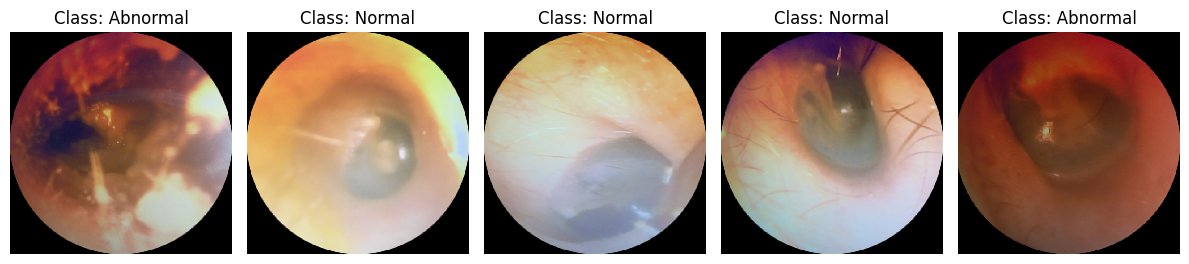

In [19]:
# plot the augmented train images
import matplotlib.pyplot as plt

# Set the number of images to plot
num_images = 5

# Get a batch of augmented images and labels from train_data
augmented_images, augmented_labels = next(train_generator)

# Plot the augmented images
fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = augmented_images[i]
    label = augmented_labels[i]

    axes[i].imshow(image)
    # axes[i].set_title(f'Label: {label}')

    class_cat = index_class[np.argmax(label)]
    axes[i].set_title(f'Class: {class_cat}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 2. Model

- Xception

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model without the top layer
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pretrained layers
for layer in vgg16_model.layers:
    layer.trainable = False

# Add custom layers on top of the pretrained model
x = Flatten()(vgg16_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the new model
vgg16_custom = Model(inputs=vgg16_model.input, outputs=predictions)

# Build the model
vgg16_custom.build(input_shape=(None, 224, 224, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [21]:
vgg16_custom.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
from tensorflow.keras.optimizers import Adam

vgg16_custom.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

- ReduceLROnPlateau:
  - 검증 손실(val_loss)이 10번의 에포크(patience)동안 향상되지 않으면 학습률(learning rate)을 0.1배(factor)로 감소시킵니다.
  - 이는 학습 도중 학습률을 동적으로 조절하여 학습을 안정화시키는 데 사용됩니다.
- EarlyStopping:
  - 검증 손실(val_loss)이 20번의 에포크(patience)동안 향상되지 않으면 학습을 조기에 종료합니다.
  - 이를 통해 과적합을 방지하고 효율적인 학습을 할 수 있습니다.
- ModelCheckpoint:
  - 검증 손실(val_loss)이 가장 낮을 때 모델을 저장합니다.
  - 이를 통해 최상의 성능을 보이는 모델을 저장하여 나중에 재사용할 수 있습니다.

In [23]:
# 활성 세션 내 모델 저장소 디렉토리 생성
os.makedirs('/content/model/')

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

model_path = "/content/model/" # 모델 저장 경로(활성 세션 내)
checkpoint_cb = ModelCheckpoint(filepath=model_path + "vgg16_model_1.h5", save_best_only=True,
                                monitor='val_loss', mode='min', verbose=1) # 모델 이름 수정할 것

# epochs = 100
history_aug = vgg16_custom.fit(train_generator, validation_data=validation_generator,
                               epochs=70, callbacks=[ely_cb, checkpoint_cb])

Epoch 1/70
31/31 [==============================] - ETA: 0s - loss: 1.4311 - accuracy: 0.6805
Epoch 1: val_loss improved from inf to 0.56884, saving model to /content/model/vgg16_model_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 178s 6s/step - loss: 1.4311 - accuracy: 0.6805 - val_loss: 0.5688 - val_accuracy: 0.7642
Epoch 2/70
31/31 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.7718
Epoch 2: val_loss improved from 0.56884 to 0.51909, saving model to /content/model/vgg16_model_1.h5
31/31 [==============================] - 9s 277ms/step - loss: 0.5184 - accuracy: 0.7718 - val_loss: 0.5191 - val_accuracy: 0.7642
Epoch 3/70
31/31 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.7718
Epoch 3: val_loss improved from 0.51909 to 0.49713, saving model to /content/model/vgg16_model_1.h5
31/31 [==============================] - 8s 248ms/step - loss: 0.4958 - accuracy: 0.7718 - val_loss: 0.4971 - val_accuracy: 0.7642
Epoch 4/70
31/31 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.7801
Epoch 4: val_loss improved from 0.49713 to 0.47039, saving model to /content/model/vgg16_model_1.h5
31/31 [===================

In [ ]:
# 30에폭에 30분 소요

### ※ 세션 내에 모델 저장했을 경우, 드라이브에 모델 저장하기(선택)

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
loaded_model = load_model("/content/model/xception_model_1.h5")

In [ ]:
# 모델 저장

# 새로운 경로 설정
new_model_path = "/content/drive/MyDrive/eardrum/model/"

loaded_model.save(new_model_path + "xception_model_2.h5") # 모델 이름 수정할 것

# 3. Check Model Performance

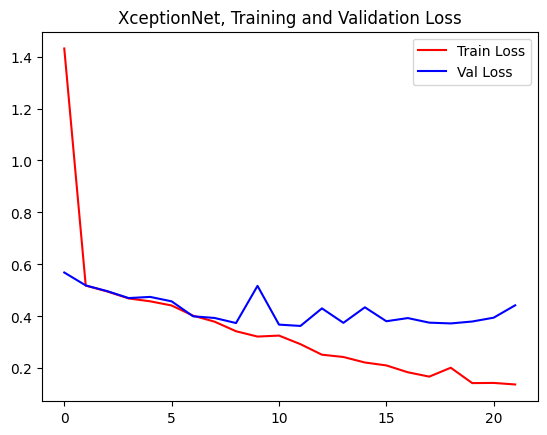

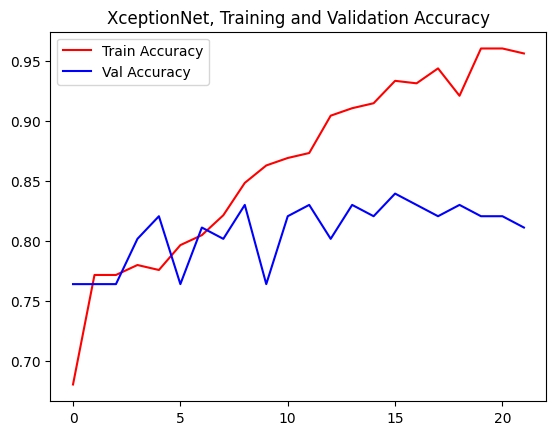

In [26]:
from matplotlib import pyplot as plt

plt.plot(history_aug.history['loss'], 'r', label = 'Train Loss')
plt.plot(history_aug.history['val_loss'], 'b', label = 'Val Loss')
plt.title('XceptionNet, Training and Validation Loss')
plt.legend()

plt.show()

plt.plot(history_aug.history['accuracy'], 'r', label = 'Train Accuracy')
plt.plot(history_aug.history['val_accuracy'], 'b', label = 'Val Accuracy')
plt.title('XceptionNet, Training and Validation Accuracy')
plt.legend()
plt.show()

In [27]:
test_loss, test_accuracy = vgg16_custom.evaluate(test_generator)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

7/7 [==============================] - 31s 5s/step - loss: 0.5761 - accuracy: 0.7453
Test Loss:  0.5760992765426636
Test Accuracy:  0.7452830076217651


In [28]:
index_class

{0: 'Abnormal', 1: 'Normal'}

In [30]:
y_pred = vgg16_custom.predict(test_generator)
predicted_classes = np.argmax(y_pred, axis=1)

7/7 [==============================] - 2s 266ms/step


In [31]:
true_classes = test_generator.classes

In [32]:
error_indices = np.where(predicted_classes != true_classes)[0]

# test data에 대해 잘못 예측한 경우

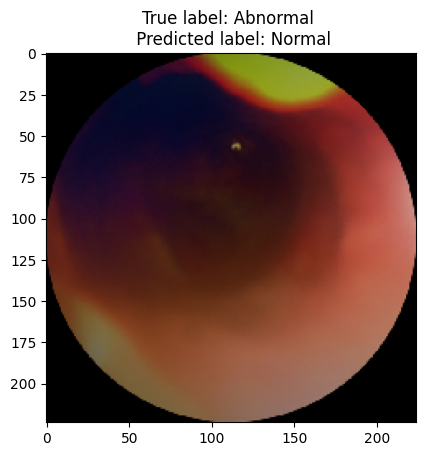

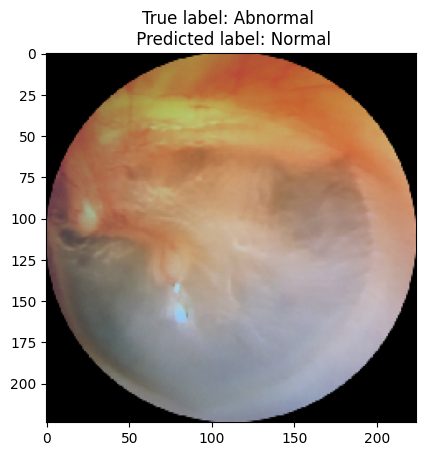

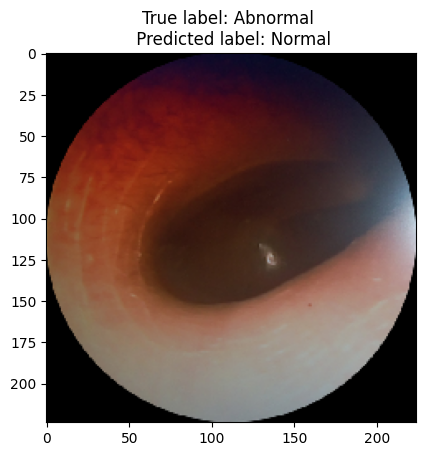

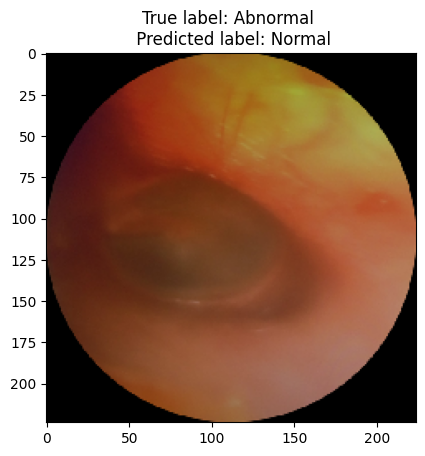

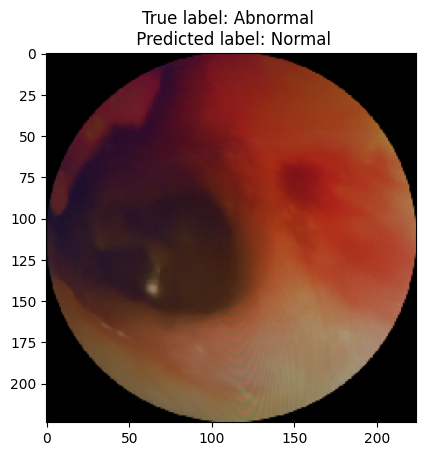

In [33]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# let's say you want to see the first 5 misclassified images
for i in range(5):
    error_index = error_indices[i]

    img_path = test_generator.filepaths[error_index]
    img = image.load_img(img_path, target_size=(224, 224))  # assuming this was your input size

    true_label = index_class[true_classes[error_index]]
    predicted_label = index_class[predicted_classes[error_index]]

    plt.figure()
    plt.imshow(img)
    plt.title(f"True label: {true_label} \n Predicted label: {predicted_label}")
    plt.show()

# Confusion Matrix

In [34]:
class_labels = list(test_generator.class_indices.keys())  # get the labels as a list

In [35]:
class_labels

['Abnormal', 'Normal']

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(true_classes, predicted_classes)

In [37]:
conf_matrix

array([[ 9, 16],
       [31, 50]])

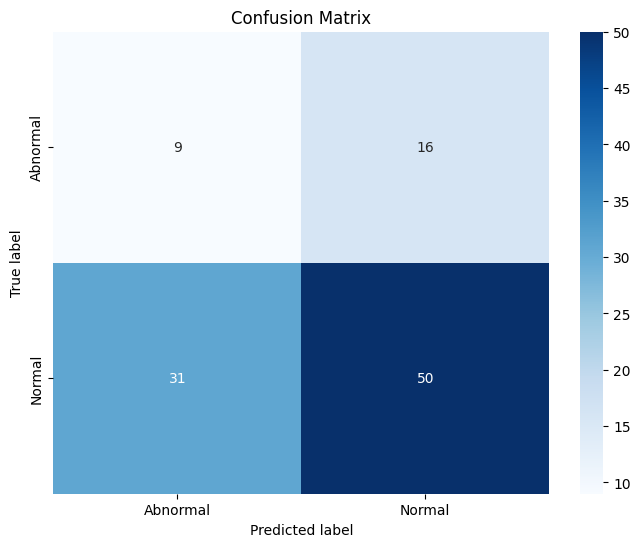

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# classification_report

In [ ]:
print(classification_report(true_classes, predicted_classes, digits=2))

              precision    recall  f1-score   support

           0       0.16      0.17      0.16        18
           1       0.00      0.00      0.00        10
           2       0.26      0.33      0.29        21
           3       0.63      0.64      0.64        81
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         5

    accuracy                           0.44       142
   macro avg       0.18      0.19      0.18       142
weighted avg       0.42      0.44      0.43       142



In [ ]:
# 거의 다 Normal로 예측해버림;;;;;;;; -> 데이터 불균형 때문
# 데이터 증강이 매우매우매우매우매우 중요할듯.

# F1 score